# Art Generator Size 512


Change the images to be saved to tensorboard

In [0]:
# https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

from __future__ import print_function
import argparse
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
from torch.utils.tensorboard import SummaryWriter

import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils

%matplotlib inline

In [2]:
# mounts the google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Parameters

In [0]:
# Set random seed for reproducibility
SEED = 0
random.seed(SEED)
torch.manual_seed(SEED)

# images
DATA_DIR = '/content/drive/My Drive/repos'
IMG_DIR = DATA_DIR + '/art_generator/data_raw/'
IMG_SIZE = 512
N_CHANNELS = 3

# graph
GEN_INPUT_SIZE = 100
N_GEN_CHANNELS = 16
N_DISC_CHANNELS = 16
beta1 = 0.5

# training
N_EPOCHS = 10
LR = 0.0002
N_WORKERS = 2
BATCH_SIZE = 8
ngpu = 1

# checkpoints and logs
LOAD_CHECKPOINT = False # False will overwrite the existing checkpoint
CHECKPOINT_PTH = DATA_DIR + '/art_generator/data_out/model_checkpoints/checkpoint_1.pt'
LOGDIR = DATA_DIR + '/art_generator/data_out/logs/size-' + str(IMG_SIZE)
epoch_counter = 0

### Dataloader

In [4]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=IMG_DIR,
                           transform=transforms.Compose([
                               transforms.Resize(IMG_SIZE),
                               transforms.RandomHorizontalFlip(p=0.5),
                               transforms.RandomVerticalFlip(p=0.5),
                               transforms.CenterCrop(IMG_SIZE),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=N_WORKERS)

print('Size of dataset: ' + str(len(dataloader.dataset.samples)))

Size of dataset: 326


In [0]:
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

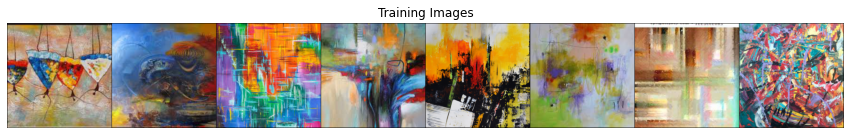

In [6]:
# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(15, 15))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [0]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

## Models

### Generator

In [0]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu

        self.convT1 = nn.ConvTranspose2d(GEN_INPUT_SIZE, N_GEN_CHANNELS * 2, 4, 1, 0, bias=False)
        self.convT2 = nn.ConvTranspose2d(N_GEN_CHANNELS * 2, N_GEN_CHANNELS * 2, 4, 2, 1, bias=False)
        self.convT3 = nn.ConvTranspose2d(N_GEN_CHANNELS * 2, N_GEN_CHANNELS * 2, 4, 2, 1, bias=False)
        self.convT4 = nn.ConvTranspose2d(N_GEN_CHANNELS * 2, N_GEN_CHANNELS * 2, 4, 2, 1, bias=False)
        self.convT5 = nn.ConvTranspose2d(N_GEN_CHANNELS * 2, N_GEN_CHANNELS * 2, 4, 2, 1, bias=False)
        self.convT6 = nn.ConvTranspose2d(N_GEN_CHANNELS * 2, N_GEN_CHANNELS * 2, 4, 2, 1, bias=False)
        self.convT7 = nn.ConvTranspose2d(N_GEN_CHANNELS * 2, N_GEN_CHANNELS * 2, 4, 2, 1, bias=False)
        self.convT8 = nn.ConvTranspose2d(N_GEN_CHANNELS * 2, N_CHANNELS, 4, 2, 1, bias=False)

        self.batch = nn.BatchNorm2d(N_GEN_CHANNELS * 2)

        self.relu = nn.ReLU(True)
        self.tanh = nn.Tanh()

    def forward(self, x):
        # layer 1: 4
        x = self.convT1(x)
        x = self.batch(x)
        x = self.relu(x)
        # layer 2: 8
        x = self.convT2(x)
        x = self.batch(x)
        x = self.relu(x)
        # layer 3: 16
        x = self.convT3(x)
        x = self.batch(x)
        x = self.relu(x)
        # layer 4: 32
        x = self.convT4(x)
        x = self.batch(x)
        x = self.relu(x)
        # layer 5: 64
        x = self.convT5(x)
        x = self.batch(x)
        x = self.relu(x)
        # layer 6: 128
        x = self.convT6(x)
        x = self.batch(x)
        x = self.relu(x)    
        # layer 7: 256
        x = self.convT7(x)
        x = self.batch(x)
        x = self.relu(x)
        # layer 8: 512
        x = self.convT8(x)
        x = self.tanh(x)

        return x

In [9]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

Generator(
  (convT1): ConvTranspose2d(100, 32, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (convT2): ConvTranspose2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (convT3): ConvTranspose2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (convT4): ConvTranspose2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (convT5): ConvTranspose2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (convT6): ConvTranspose2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (convT7): ConvTranspose2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (convT8): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (batch): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (tanh): Tanh()
)

In [0]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu

        self.conv1 = nn.Conv2d(N_CHANNELS, N_DISC_CHANNELS, 4, 2, 1, bias=False)
        self.conv2 = nn.Conv2d(N_DISC_CHANNELS, N_DISC_CHANNELS * 2, 4, 2, 1, bias=False)
        self.conv3 = nn.Conv2d(N_DISC_CHANNELS * 2, N_DISC_CHANNELS * 2, 4, 2, 1, bias=False)
        self.conv4 = nn.Conv2d(N_DISC_CHANNELS * 2, N_DISC_CHANNELS * 2, 4, 2, 1, bias=False)
        self.conv5 = nn.Conv2d(N_DISC_CHANNELS * 2, N_DISC_CHANNELS * 2, 4, 2, 1, bias=False)
        self.conv6 = nn.Conv2d(N_DISC_CHANNELS * 2, N_DISC_CHANNELS * 2, 4, 2, 1, bias=False)
        self.conv7 = nn.Conv2d(N_DISC_CHANNELS * 2, N_DISC_CHANNELS * 2, 4, 2, 1, bias=False)
        self.conv8 = nn.Conv2d(N_DISC_CHANNELS * 2, 1, 4, 1, 0, bias=False)

        self.batch = nn.BatchNorm2d(N_DISC_CHANNELS * 2)

        self.LeakyReLU = nn.LeakyReLU(0.2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # layer 1
        x = self.conv1(x)
        x = self.LeakyReLU(x)
        # layer 2
        x = self.conv2(x)
        x = self.batch(x)
        x = self.LeakyReLU(x)
        # layer 3
        x = self.conv3(x)
        x = self.batch(x)
        x = self.LeakyReLU(x)
        # layer 4
        x = self.conv4(x)
        x = self.batch(x)
        x = self.LeakyReLU(x)
        # layer 5
        x = self.conv5(x)
        x = self.batch(x)
        x = self.LeakyReLU(x)
        # layer 6
        x = self.conv6(x)
        x = self.batch(x)
        x = self.LeakyReLU(x)
        # layer 7
        x = self.conv7(x)
        x = self.batch(x)
        x = self.LeakyReLU(x)
        # layer 8
        x = self.conv8(x)
        x = self.sigmoid(x)

        return x

In [11]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

Discriminator(
  (conv1): Conv2d(3, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv2): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv3): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv4): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv5): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv6): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv7): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv8): Conv2d(32, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (batch): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (LeakyReLU): LeakyReLU(negative_slope=0.2)
  (sigmoid): Sigmoid()
)

### Loss functions and optimizers

In [0]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, GEN_INPUT_SIZE, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=LR, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=LR, betas=(beta1, 0.999))

### Loads Checkpoint

In [0]:
if LOAD_CHECKPOINT:
    # loads the model weights
    checkpoint = torch.load(CHECKPOINT_PTH)
    netG.load_state_dict(checkpoint['netG_state'])
    optimizerG.load_state_dict(checkpoint['optimizerG'])
    netD.load_state_dict(checkpoint['netD_state'])
    optimizerD.load_state_dict(checkpoint['optimizerD'])
    print('Checkpoint Loaded')
    
    # loads the epoch counter
    with open(LOGDIR + '/itercount.txt', 'r') as f:
        epoch_counter = int(f.read())

## Training

In [14]:
# Training Loop
writer = SummaryWriter(LOGDIR)

# Lists to keep track of progress
img_list = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(N_EPOCHS):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)

        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, GEN_INPUT_SIZE, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # tasks for each epoch
        if i == 0:
            # print the status
            print('EPOCH: [%d/%d] BATCH: [%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, N_EPOCHS, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

            # saves a checkpoint        
            checkpoint = {'netG_state': netG.state_dict(), 'optimizerG': optimizerG.state_dict(),
                          'netD_state': netD.state_dict(), 'optimizerD': optimizerD.state_dict()}
            torch.save(checkpoint, CHECKPOINT_PTH)
            
            # writes the log count
            with open(LOGDIR + '/itercount.txt', 'w') as f:
                f.write(str(epoch_counter))


        # every x epochs we save the images for comparing the training
        # if epoch % 10 == 0:
            # saves images so we can see the progression
            # output = netG(fixed_noise).detach().cpu()
            # writer.add_image('four_fashion_mnist_images', img_scale(output[0]))

            # with torch.no_grad():
            #     output = netG(fixed_noise).detach().cpu()
            # img_list.append(output[0])


        # Save Losses for plotting later
        writer.add_scalar('Loss/Gen', errG.item(), epoch_counter)
        writer.add_scalar('Loss/Disc', errD.item(), epoch_counter)
                
    epoch_counter += 1

writer.close()

Starting Training Loop...
EPOCH: [0/10] BATCH: [0/41]	Loss_D: 1.4567	Loss_G: 1.0337	D(x): 0.5073	D(G(z)): 0.5321 / 0.3580
EPOCH: [1/10] BATCH: [0/41]	Loss_D: 1.1499	Loss_G: 1.1455	D(x): 0.6766	D(G(z)): 0.5181 / 0.3287
EPOCH: [2/10] BATCH: [0/41]	Loss_D: 0.5222	Loss_G: 2.1161	D(x): 0.7938	D(G(z)): 0.2416 / 0.1234
EPOCH: [3/10] BATCH: [0/41]	Loss_D: 0.2348	Loss_G: 2.4761	D(x): 0.9493	D(G(z)): 0.1652 / 0.0863
EPOCH: [4/10] BATCH: [0/41]	Loss_D: 0.1289	Loss_G: 3.1307	D(x): 0.9784	D(G(z)): 0.1014 / 0.0440
EPOCH: [5/10] BATCH: [0/41]	Loss_D: 0.0651	Loss_G: 3.5592	D(x): 0.9855	D(G(z)): 0.0492 / 0.0295
EPOCH: [6/10] BATCH: [0/41]	Loss_D: 0.0774	Loss_G: 3.6513	D(x): 0.9885	D(G(z)): 0.0637 / 0.0263
EPOCH: [7/10] BATCH: [0/41]	Loss_D: 0.0985	Loss_G: 6.0411	D(x): 0.9121	D(G(z)): 0.0025 / 0.0024
EPOCH: [8/10] BATCH: [0/41]	Loss_D: 0.0180	Loss_G: 4.8583	D(x): 0.9900	D(G(z)): 0.0079 / 0.0078
EPOCH: [9/10] BATCH: [0/41]	Loss_D: 0.0743	Loss_G: 7.3350	D(x): 0.9321	D(G(z)): 0.0007 / 0.0007


## Results Review

In [0]:
# helper function for converting images to a normal range
def img_scale(img_tensor):
    min_value = img_tensor.min()
    span = img_tensor.max() - img_tensor.min()
    img_tensor = (img_tensor - min_value) / span
    img_tensor = np.transpose(img_tensor)

    # converts to 255
    img = img_tensor.data.numpy()
    img = img * 255
    img = img.astype(np.uint8)

    return img

### Image over training process

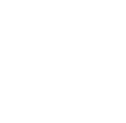

In [16]:
#%%capture
fig = plt.figure(figsize=(2,2))
plt.axis("off")
ims = [[plt.imshow(img_scale(i), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

### Batch of real vs fake images

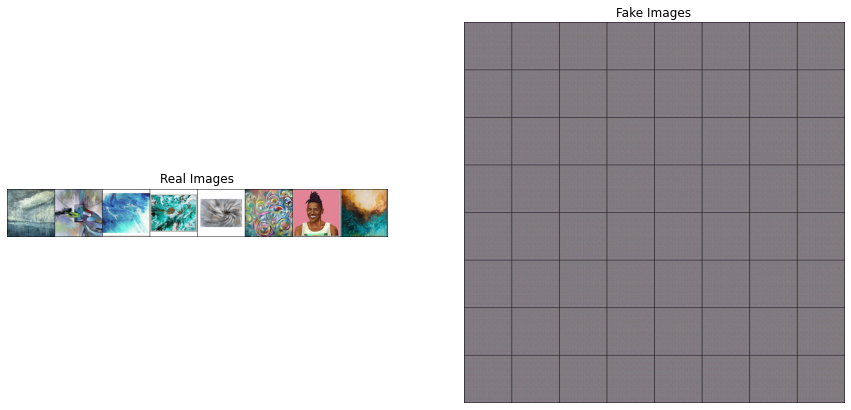

In [17]:
# makes teh image list
with torch.no_grad():
    fake = netG(fixed_noise).detach().cpu()
img_list.append(vutils.make_grid(fake, padding=5, normalize=True))

# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

### A random image

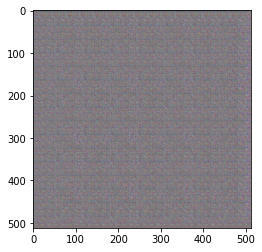

In [18]:
noise = torch.randn(b_size, GEN_INPUT_SIZE, 1, 1, device=device)
output = netG(noise).detach().cpu()
plt.imshow(img_scale(output[0]))

In [0]:
from PIL import Image
import torchvision
# img = img_scale(output[0])
# Image.fromarray(img)

In [0]:
writer = SummaryWriter(LOGDIR)
grid = torchvision.utils.make_grid(output[0])
writer.add_image('four_fashion_mnist_images', grid, 0)
writer.close()

In [102]:
LOGDIR

'/content/drive/My Drive/repos/art_generator/data_out/logs/size-512'